# 資料集
## https://www.kaggle.com/mhskjelvareid/dagm-2007-competition-dataset-optical-inspection

In [1]:
!sudo apt update
!sudo apt install libopencv-dev python3-opencv -y

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
41 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopencv-dev is already the newest version (4.2.0+dfsg-5).
python3-opencv is already the newest version (4.2.0+dfsg-5).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [2]:
import cv2
from tqdm import tqdm 
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from robust_confusion_matrix import robust_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
img = cv2.imread('./DAGM_KaggleUpload/Class6/Train/0576.PNG')

In [4]:
img.shape

(512, 512, 3)

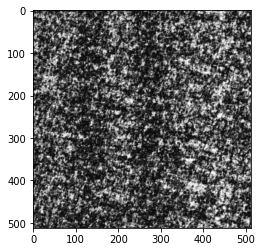

In [5]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
img = cv2.imread('./DAGM_KaggleUpload/Class6/Train/0579.PNG')

In [7]:
img.shape

(512, 512, 3)

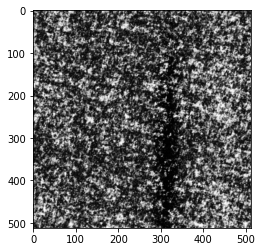

In [8]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
mask = cv2.imread('./DAGM_KaggleUpload/Class6/Train/Label/0579_label.PNG')

In [10]:
mask.shape

(512, 512, 3)

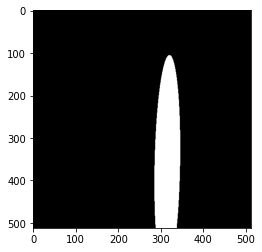

In [11]:
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

# 產生data frame

In [12]:
import pandas as pd

In [13]:
df = pd.read_table('./DAGM_KaggleUpload/Class6/Train/Label/Labels.txt',sep='\t',header=0, names=['NG','img_name','0','NG_label','NaN'])
df

,NG,img_name,0,NG_label,NaN
576,0,0576.PNG,0,0,NaN
577,0,0577.PNG,0,0,NaN
578,0,0578.PNG,0,0,NaN
579,1,0579.PNG,0,0579_label.PNG,NaN
580,0,0580.PNG,0,0,NaN
...,...,...,...,...,...
1146,0,1146.PNG,0,0,NaN
1147,0,1147.PNG,0,0,NaN
1148,0,1148.PNG,0,0,NaN
1149,0,1149.PNG,0,0,NaN


In [14]:
df = df[['NG', 'img_name']]
df

,NG,img_name
576,0,0576.PNG
577,0,0577.PNG
578,0,0578.PNG
579,1,0579.PNG
580,0,0580.PNG
...,...,...
1146,0,1146.PNG
1147,0,1147.PNG
1148,0,1148.PNG
1149,0,1149.PNG


In [15]:
df['PASS'] = 1
df

,NG,img_name,PASS
576,0,0576.PNG,1
577,0,0577.PNG,1
578,0,0578.PNG,1
579,1,0579.PNG,1
580,0,0580.PNG,1
...,...,...,...
1146,0,1146.PNG,1
1147,0,1147.PNG,1
1148,0,1148.PNG,1
1149,0,1149.PNG,1


In [16]:
df['PASS'][df['NG'] ==1] = 0
df

,NG,img_name,PASS
576,0,0576.PNG,1
577,0,0577.PNG,1
578,0,0578.PNG,1
579,1,0579.PNG,0
580,0,0580.PNG,1
...,...,...,...
1146,0,1146.PNG,1
1147,0,1147.PNG,1
1148,0,1148.PNG,1
1149,0,1149.PNG,1


In [17]:
df_PASS = df_PASS = df[df['PASS'] == 1]
df_PASS

,NG,img_name,PASS
576,0,0576.PNG,1
577,0,0577.PNG,1
578,0,0578.PNG,1
580,0,0580.PNG,1
582,0,0582.PNG,1
...,...,...,...
1146,0,1146.PNG,1
1147,0,1147.PNG,1
1148,0,1148.PNG,1
1149,0,1149.PNG,1


In [18]:
df_NG = df[df['NG'] == 1]
df_NG

,NG,img_name,PASS
579,1,0579.PNG,0
581,1,0581.PNG,0
587,1,0587.PNG,0
598,1,0598.PNG,0
599,1,0599.PNG,0
...,...,...,...
1112,1,1112.PNG,0
1115,1,1115.PNG,0
1124,1,1124.PNG,0
1130,1,1130.PNG,0


## 分成訓練集與驗證集

In [19]:
df_train_PASS = df_PASS.sample(frac=0.9, random_state=33)
df_val_PASS = df_PASS.drop(df_train_PASS.index)

In [20]:
df_train_NG = df_NG.sample(frac=0.9, random_state=33)
df_val_NG = df_NG.drop(df_train_NG.index)

## PASS 跟 NG 資料不平衡

In [21]:
df_train_PASS.shape

(443, 3)

In [22]:
df_train_NG.shape

(75, 3)

In [23]:
# 資料不平衡，將訓練資料集中的NG複製5份
df_train = df_train_PASS
for _ in range(df_train_PASS.shape[0]//df_train_NG.shape[0] + 1):
    df_train = pd.concat([df_train, df_train_NG])
df_train

,NG,img_name,PASS
1132,0,1132.PNG,1
922,0,0922.PNG,1
639,0,0639.PNG,1
1088,0,1088.PNG,1
876,0,0876.PNG,1
...,...,...,...
785,1,0785.PNG,0
820,1,0820.PNG,0
868,1,0868.PNG,0
856,1,0856.PNG,0


In [24]:
df_val = pd.concat([df_val_PASS, df_val_NG], ignore_index=True)
df_val

,NG,img_name,PASS
0,0,0585.PNG,1
1,0,0595.PNG,1
2,0,0601.PNG,1
3,0,0604.PNG,1
4,0,0609.PNG,1
5,0,0615.PNG,1
6,0,0619.PNG,1
7,0,0651.PNG,1
8,0,0655.PNG,1
9,0,0660.PNG,1


# 資料擴增

In [25]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2021-10-24 03:46:49.774752: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


In [26]:
input_size = (224,224)
batch_size = 32
epoch = 50
label = {'PASS':0, 'NG':1}
classes=['PASS','NG']
num_classes  = len(label)

In [27]:
path = './DAGM_KaggleUpload/Class6/Train/'

train_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input)

In [28]:
train_generator = train_datagen.flow_from_dataframe(
dataframe=df_train, 
directory=path, 
x_col="img_name", y_col=['PASS','NG'], 
class_mode="raw",
target_size=input_size,
# color_mode='grayscale',
batch_size=batch_size,
shuffle=True,
save_prefix='',
save_format='png',
interpolation='nearest')

Found 893 validated image filenames.


In [29]:
validation_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_dataframe(
dataframe=df_val, 
directory=path, 
x_col="img_name", y_col=['PASS','NG'], 
shuffle=False,
# color_mode='grayscale',
class_mode='raw',
target_size=input_size)

Found 57 validated image filenames.


In [30]:
# 訓練資料集數量
train_generator.n

893

In [31]:
# 驗證資料集數量
validation_generator.n

57

In [32]:
# 每一次產生一個tuple 型態的資料 : (影像xbatchsize,labelxbatchsize)
train_generator.next()

(array([[[[-8.9939003e+01, -1.0277900e+02, -1.0968000e+02],
          [-6.3939003e+01, -7.6778999e+01, -8.3680000e+01],
          [ 8.6060997e+01,  7.3221001e+01,  6.6320000e+01],
          ...,
          [-8.1939003e+01, -9.4778999e+01, -1.0168000e+02],
          [-8.6939003e+01, -9.9778999e+01, -1.0668000e+02],
          [-7.9939003e+01, -9.2778999e+01, -9.9680000e+01]],
 
         [[-7.2939003e+01, -8.5778999e+01, -9.2680000e+01],
          [-3.9939003e+01, -5.2778999e+01, -5.9680000e+01],
          [-7.9390030e+00, -2.0778999e+01, -2.7680000e+01],
          ...,
          [-8.1939003e+01, -9.4778999e+01, -1.0168000e+02],
          [-5.5939003e+01, -6.8778999e+01, -7.5680000e+01],
          [-4.7939003e+01, -6.0778999e+01, -6.7680000e+01]],
 
         [[-4.2939003e+01, -5.5778999e+01, -6.2680000e+01],
          [-1.1939003e+01, -2.4778999e+01, -3.1680000e+01],
          [-2.2939003e+01, -3.5778999e+01, -4.2680000e+01],
          ...,
          [-6.4939003e+01, -7.7778999e+01, -8.468

In [33]:
(img_b, label_b) = train_generator.next()

In [34]:
# batch labels' shape:(batch, label)
label_b.shape

(32, 2)

In [35]:
# print(lbael)
label_b

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [36]:
# batch images' shape: (batch, h, w, channel)
img_b.shape

(32, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1 0]


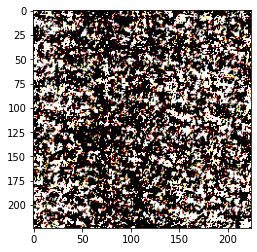

In [37]:
i = 0 # index of batch
print(label_b[i])
plt.imshow(img_b[i])

## 每次訓練的圖片張數

In [38]:
def num_steps_per_epoch(data_generator, batch_size):
    if data_generator.n % batch_size==0:
        return data_generator.n//batch_size
    else:
        return data_generator.n//batch_size + 1

train_steps = num_steps_per_epoch(train_generator, batch_size)
validation_steps = num_steps_per_epoch(validation_generator, batch_size)

In [39]:
train_steps

28

In [40]:
validation_steps

2

## 參數設定

In [41]:
path = './DAGM_KaggleUpload/Class6/Train/'

train_datagen = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
zca_epsilon=0,  # epsilon for ZCA whitening  1e-06

rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)

width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    
shear_range=0.1,  # set range for random shear
zoom_range=0.1,  # set range for random zoom

channel_shift_range=0.,  # set range for random channel shifts
    
# set mode for filling points outside the input boundaries
# 'constant', 'nearest', 'reflect', 'wrap'
fill_mode='nearest',
cval=0.,  # value used for fill_mode = "constant"
    
horizontal_flip=True,  # randomly flip images
vertical_flip=True,  # randomly flip images
    
# set rescaling factor (applied before any other transformation)
rescale=None,
    
# set function that will be applied on each input
preprocessing_function=preprocess_input,
    
# image data format, either "channels_first" or "channels_last"
data_format=None,
# fraction of images reserved for validation (strictly between 0 and 1)
validation_split=0.0)

In [42]:
train_generator = train_datagen.flow_from_dataframe(
dataframe=df_train, 
directory=path, 
x_col="img_name", y_col=['PASS','NG'], 
class_mode="raw", 
target_size=input_size,
# color_mode='grayscale',
classes=None,
batch_size=batch_size,
shuffle=True,
seed=None,
save_to_dir=None,
save_prefix='',
save_format='png',
follow_links=False,
subset=None,
interpolation='nearest')

Found 893 validated image filenames.


In [43]:
validation_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_dataframe(
dataframe=df_val, 
directory=path, 
x_col="img_name", y_col=['PASS','NG'], 
shuffle=False,
# color_mode='grayscale',
class_mode='raw',
target_size=input_size)

Found 57 validated image filenames.


In [44]:
(img_b, label_b) = train_generator.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]


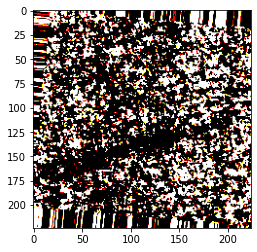

In [45]:
i = 0 # index of batch
print(label_b[i])
plt.imshow(img_b[i])